# MPC Demo with `mpc_local_planner` Classes (ROS‑free)

This notebook mirrors the original live simulation and plot, but swaps in the key classes from your `mpc_local_planner`:
- `Optimizer`
- `ObstaclePenalty` + `ObstacleParams`
- `Pose2D`, `Twist2D`, `Robot`
- A minimal `TrajectoryPlanner` compatible with a notebook (no TF, no ROS)
- A lightweight `CostmapGrid` wrapper fed by a synthetic grid

Goal: keep the same virtual environment and the live plot at the end. No ROS or Gazebo needed.


In [25]:
import math, time, random
import numpy as np
import torch
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Dict, Any, Tuple

torch.set_printoptions(precision=4, sci_mode=False)
np.set_printoptions(precision=3, suppress=True)

# Common alias
Tensor = torch.Tensor

# ---- Synthetic costmap generator (Gaussian bumps) ----
def make_gaussian_costmap(W, H, res, peaks):
    """
    Return a tuple (grid, ox, oy, res) where grid is shape [H, W] in [0,1].
    peaks: list of tuples (wx, wy, sigma, strength) in world meters.
    """
    ox, oy = 0.0, 0.0  # origin
    xs = (np.arange(W) + 0.5) * res + ox
    ys = (np.arange(H) + 0.5) * res + oy
    X, Y = np.meshgrid(xs, ys)
    G = np.zeros((H, W), dtype=np.float32)
    for (wx, wy, sigma, strength) in peaks:
        G += strength * np.exp(-((X-wx)**2 + (Y-wy)**2) / (2*sigma**2))
    G = np.clip(G, 0.0, 1.0).astype(np.float32)
    return G, ox, oy, res

### Pose and PoseArray

We represent a planar robot pose as $p = (x, y, \theta) \in \mathbb{R}^2 \times S^1$.

- A Pose is a single triplet $(x, y, \theta)$.
- A PoseArray is an ordered list $[p_0, p_1, \dots, p_{K-1}]$ used for horizons or paths.

In [26]:
from dataclasses import dataclass

@dataclass
class Pose:
    x: float
    y: float
    yaw: float

class PoseArray:
    def __init__(self):
        self.poses: list[Pose] = []  # list of Pose

### Pose2D

A differentiable state vector $x = [x, y, \theta]^\top$.
- Conversion: $x = \operatorname{stack}(x, y, \theta)$.
- Angle wrapping: $\operatorname{wrap}(\theta) = \operatorname{atan2}(\sin\theta, \cos\theta)$.

In [27]:
from dataclasses import dataclass as _dc

@_dc
class Pose2D:
    x: Tensor
    y: Tensor
    theta: Tensor
    
    @staticmethod
    def from_xytheta(x: float, y: float, theta: float) -> "Pose2D":
        return Pose2D(torch.tensor(x, dtype=torch.float32),
                      torch.tensor(y, dtype=torch.float32),
                      torch.tensor(theta, dtype=torch.float32))
    
    def as_vector(self) -> Tensor:
        return torch.stack([self.x, self.y, self.theta])
    
    @staticmethod
    def from_vector(v: Tensor) -> "Pose2D":
        return Pose2D(v[0], v[1], v[2])

### Twist2D

Control vector $u = [v, \omega]^\top$ with linear speed $v$ and angular speed $\omega$.
- Stacking: $u = \operatorname{stack}(v, \omega)$.

In [28]:
from dataclasses import dataclass as _dc

@_dc
class Twist2D:
    v: Tensor
    omega: Tensor
    def as_vector(self) -> Tensor:
        return torch.stack([self.v, self.omega])
    
    @staticmethod
    def from_vector(u: Tensor) -> "Twist2D":
        return Twist2D(u[0], u[1])

### Robot (unicycle kinematics + saturation)

Discrete-time unicycle with step $\Delta t$ and control $u=[v_k,\omega_k]^\top$.
```math
\begin{bmatrix}
x_{k+1}\\
y_{k+1}\\
\theta_{k+1}
\end{bmatrix}
=
\begin{bmatrix}
x_k\\
y_k\\
\theta_k
\end{bmatrix}
+
\Delta T\,
\begin{bmatrix}
\cos\theta_k & 0\\
\sin\theta_k & 0\\
0 & 1
\end{bmatrix}
\begin{bmatrix}
v_k\\
\omega_k
\end{bmatrix}.
```

Saturation (clamp):

```math
    v_{\min}\!\le\!v_k\!\le\!v_{\max},\quad
    \omega_{\min}\!\le\!\omega_k\!\le\!\omega_{\max}
```

In [29]:
class Robot:
    def __init__(self, dt: float, v_limits: tuple[float, float],
                 w_limits: tuple[float, float],
                 footprint_radius: float, safety_margin: float):
        self.dt = float(dt)
        self.v_min, self.v_max = v_limits
        self.w_min, self.w_max = w_limits
        self.footprint_radius = float(footprint_radius)
        self.safety_margin = float(safety_margin)

    @staticmethod
    def _wrap_angle(a: Tensor) -> Tensor:
        return torch.atan2(torch.sin(a), torch.cos(a))

    def clamp(self, u: Twist2D, v_min=None, v_max=None, w_min=None, w_max=None) -> Twist2D:
        vmin = self.v_min if v_min is None else float(v_min)
        vmax = self.v_max if v_max is None else float(v_max)
        wmin = self.w_min if w_min is None else float(w_min)
        wmax = self.w_max if w_max is None else float(w_max)
        v = torch.clamp(u.v, min=vmin, max=vmax)
        w = torch.clamp(u.omega, min=wmin, max=wmax)
        return Twist2D(v, w)

    def step(self, x: Pose2D, u: Twist2D) -> Pose2D:
        v, w = u.v, u.omega
        T = self.dt
        xn = x.x + T * v * torch.cos(x.theta)
        yn = x.y + T * v * torch.sin(x.theta)
        thn = self._wrap_angle(x.theta + T * w)
        return Pose2D(xn, yn, thn)

### CostmapGrid (bilinear sampling)

Sample cost $c(x,y)$ from a discrete grid with bilinear interpolation.
Let $(i,j)$ be the integer cell indices and $\alpha,\beta\in[0,1]$ the fractional parts. Then
```math
c(x,y) = (1-\alpha)(1-\beta)\,c_{00} + \alpha(1-\beta)\,c_{10} + (1-\alpha)\beta\,c_{01} + \alpha\beta\,c_{11}.
```

In [30]:
class CostmapGrid:
    def __init__(self, grid: np.ndarray, ox: float, oy: float, res: float):
        self.grid = torch.from_numpy(grid.astype(np.float32))  # [H,W]
        self.H, self.W = self.grid.shape
        self.ox, self.oy, self.res = float(ox), float(oy), float(res)
        self.ready = True
        
    def sample(self, x: Tensor, y: Tensor) -> Tensor:
        if not self.ready:
            return torch.tensor(0.0, dtype=torch.float32)
        gx = (x - self.ox) / (self.res + 1e-9)
        gy = (y - self.oy) / (self.res + 1e-9)
        x0 = torch.floor(gx); y0 = torch.floor(gy)
        x1 = x0 + 1.0;        y1 = y0 + 1.0
        x0c = torch.clamp(x0, 0.0, self.W - 1.0); y0c = torch.clamp(y0, 0.0, self.H - 1.0)
        x1c = torch.clamp(x1, 0.0, self.W - 1.0); y1c = torch.clamp(y1, 0.0, self.H - 1.0)
        wx = torch.clamp(gx - x0, 0.0, 1.0); wy = torch.clamp(gy - y0, 0.0, 1.0)
        G = self.grid
        def at(ix, iy): return G[iy.long(), ix.long()]
        c00 = at(x0c, y0c); c10 = at(x1c, y0c)
        c01 = at(x0c, y1c); c11 = at(x1c, y1c)
        c0 = c00 * (1.0 - wx) + c10 * wx
        c1 = c01 * (1.0 - wx) + c11 * wx
        return c0 * (1.0 - wy) + c1 * wy

### ObstaclePenalty

We sample costs around lookahead centers and combine via a smooth maximum.
- Ring centers: $c_d = (x + d\cos\theta,\; y + d\sin\theta)$ for $d \in \text{ahead\_dists}$.
- Circle samples: points on a ring of radius $r = r_{fp}+m_{safe}$.
- Smooth max:
```math
\operatorname{smax}_\beta(\{z_i\}) = m + \frac{1}{\beta}\log\left(\frac{1}{n}\sum_i e^{\beta(z_i - m)}\right),\quad m=\max_i z_i
```
- Soft threshold: $s=\mathrm{clamp}((v-t)/(1-t), 0, 1)$; scaled penalty: $J_{obs}= w\, s^p$.

In [31]:
from dataclasses import dataclass as _dcd

@_dcd
class ObstacleParams:
    weight: float
    power: float
    thresh: float
    unknown_is_lethal: bool
    ahead_dists: List[float]
    samples_per_circle: int
    footprint_radius: float
    safety_margin: float

class ObstaclePenalty:
    def __init__(self, costmap: CostmapGrid, p: ObstacleParams):
        self.cm = costmap
        self.p = p
        self.debug: Dict[str, Any] | None = None

    @staticmethod
    def _smooth_max(values: torch.Tensor, beta: float = 8.0) -> torch.Tensor:
        m = torch.max(values)
        out = m + torch.log(torch.clamp(torch.exp((values - m) * beta).mean(), min=1e-9)) / beta
        return torch.clamp(out, 0.0, 1.0)
    
    def _soft_threshold(self, v: torch.Tensor) -> torch.Tensor:
        if self.p.unknown_is_lethal:
            v = torch.where(v >= 0.992, torch.tensor(1.0, dtype=torch.float32), v)
        t = float(self.p.thresh)
        return torch.clamp((v - t) / (1.0 - t + 1e-6), 0.0, 1.0)
    
    def _scale(self, s: torch.Tensor) -> torch.Tensor:
        return (s ** float(self.p.power)) * float(self.p.weight)
    
    def _ring_centers(self, x: Pose2D):
        c, s = torch.cos(x.theta), torch.sin(x.theta)
        centers = []
        for d in (self.p.ahead_dists or [0.0]):
            centers.append((x.x + c * float(d), x.y + s * float(d)))
        return centers
    
    def _sample_circle(self, cx, cy, c, s):
        r = float(self.p.footprint_radius + self.p.safety_margin)
        M = max(1, int(self.p.samples_per_circle))
        out = []
        if r <= 1e-6 or M == 1:
            cval = self.cm.sample(cx, cy)
            out.append((cx, cy, cval)); return out
        for j in range(M):
            phi = 2.0 * math.pi * j / M
            ox, oy = r * math.cos(phi), r * math.sin(phi)
            rx = c * ox - s * oy; ry = s * ox + c * oy
            wx = cx + rx; wy = cy + ry
            cval = self.cm.sample(wx, wy)
            out.append((wx, wy, cval))
        return out
    
    def _gather_samples(self, x: Pose2D):
        samples = []
        c, s = torch.cos(x.theta), torch.sin(x.theta)
        for cx, cy in self._ring_centers(x):
            samples.extend(self._sample_circle(cx, cy, c, s))
        return samples
    
    def evaluate(self, x: Pose2D) -> torch.Tensor:
        if not self.cm or not self.cm.ready:
            self.debug = None
            return torch.tensor(0.0, dtype=torch.float32)
        samples = self._gather_samples(x)
        if not samples:
            self.debug = None
            return torch.tensor(0.0, dtype=torch.float32)
        vals = torch.stack([c for (_, _, c) in samples], dim=0)
        v = self._smooth_max(vals)
        s = self._soft_threshold(v)
        penalty = self._scale(s)
        dbg_samples = [(float(wx.item()), float(wy.item()), float(c.item())) for (wx, wy, c) in samples]
        self.debug = {
            "state": (float(x.x.item()), float(x.y.item()), float(x.theta.item())),
            "radius": float(self.p.footprint_radius + self.p.safety_margin),
            "lookahead": list(map(float, self.p.ahead_dists or [0.0])),
            "samples": dbg_samples,
            "smooth_max": float(v.item()),
            "soft": float(s.item()),
            "penalty": float(penalty.item()),
        }
        return penalty

### Optimizer (MPC objective)

We minimize a finite-horizon cost
```math
J = \sum_{k=0}^{N-1} (x_k - r_k)^\top Q (x_k - r_k) + u_k^\top R u_k + J_{obs}(x_k)\; +\; (x_N - r_N)^\top S (x_N - r_N)
```
subject to the unicycle dynamics and control bounds. Gradient-based optimization updates $\{u_k\}$ via Adam.

In [32]:
class Optimizer:
    def __init__(self, N: int, robot, Q, R, S, T: float,
                 penalty: ObstaclePenalty,
                 iters: int = 8, time_frac: float = 0.5):
        self.N = N
        self.robot = robot
        self.Q, self.R, self.S = Q, R, S
        self.T = float(T)
        self.penalty = penalty
        self.max_iters = int(iters)
        self.time_frac = float(time_frac)
        self.U = None  # [N, 2]
        torch.set_num_threads(1)

    @staticmethod
    def wrap_angle(a: Tensor) -> Tensor:
        return torch.atan2(torch.sin(a), torch.cos(a))
    
    def init_warm_start(self):
        self.U = torch.zeros(self.N, 2, dtype=torch.float32, requires_grad=True)

    def rollout_cost(self, x0: Pose2D, ref_traj: torch.Tensor):
        x = x0
        J = torch.tensor(0.0, dtype=torch.float32)
        Xs = [x.as_vector().clone()]
        for k in range(self.N):
            u = Twist2D.from_vector(self.U[k])
            u = self.robot.clamp(u)
            x = self.robot.step(x, u)
            Xs.append(x.as_vector().clone())
            r = ref_traj[k]
            lin = x.as_vector()[:2] - r[:2]
            yaw_err = self.wrap_angle(x.theta - r[2])
            diff = torch.stack([lin[0], lin[1], yaw_err])
            J = J + diff @ self.Q @ diff + u.as_vector() @ self.R @ u.as_vector() + self.penalty.evaluate(x)
        rT = ref_traj[-1]
        linT = x.as_vector()[:2] - rT[:2]
        yawT = self.wrap_angle(x.theta - rT[2])
        diffT = torch.stack([linT[0], linT[1], yawT])
        J = J + diffT @ self.S @ diffT
        return J, torch.stack(Xs, dim=0)
    
    def solve(self, x0_vec: torch.Tensor, ref_traj: torch.Tensor):
        if self.U is None or self.U.shape[0] != self.N:
            self.init_warm_start()
        x0 = Pose2D.from_vector(x0_vec)
        optim = torch.optim.Adam([self.U], lr=0.2)
        time_budget = max(1e-3, self.time_frac * self.T)
        t0 = time.perf_counter()
        for _ in range(self.max_iters):
            optim.zero_grad(set_to_none=True)
            J, _ = self.rollout_cost(x0, ref_traj)
            J.backward()
            torch.nn.utils.clip_grad_norm_([self.U], max_norm=1.0)
            optim.step()
            if (time.perf_counter() - t0) > time_budget:
                break
        with torch.no_grad():
            _, X_pred = self.rollout_cost(x0, ref_traj)
            u0_raw = Twist2D.from_vector(self.U[0].detach())
            u0 = self.robot.clamp(u0_raw)
            src = self.U[1:].detach().clone()
            self.U[:-1].copy_(src)
            self.U[-1].zero_()
        return u0, X_pred

### TrajectoryPlanner (reference path)

Given current $(x_0,y_0,\theta_0)$ and goal $(x_g,y_g,\theta_g)$, build a straight-line reference:
```math
p_k = (1-\alpha_k)\,p_0 + \alpha_k\,p_g,\quad \alpha_k=\tfrac{k+1}{N}.
```
Heading is aligned with the line to goal until within a lock radius.

In [34]:
class TrajectoryPlanner:
    def __init__(self, lock_radius: float = 0.5):
        self.lock_radius = float(lock_radius)
        self.goal = Pose(4.5, 3.0, 0.0)

    def set_goal(self, x, y, yaw=0.0):
        self.goal = Pose(float(x), float(y), float(yaw))
        
    def build_reference(self, current_xyyaw, N: int):
        x0, y0, yaw0 = [float(v) for v in current_xyyaw]
        gx, gy, gyaw = self.goal.x, self.goal.y, self.goal.yaw
        pa = []
        d = math.hypot(gx-x0, gy-y0)
        if d <= self.lock_radius:
            for _ in range(N):
                pa.append([gx, gy, gyaw])
            return torch.tensor(pa, dtype=torch.float32)
        th_ref = math.atan2(gy-y0, gx-y0)
        for k in range(N):
            a = (k+1)/float(N)
            pa.append([x0 + a*(gx-x0), y0 + a*(gy-y0), th_ref])
        return torch.tensor(pa, dtype=torch.float32)

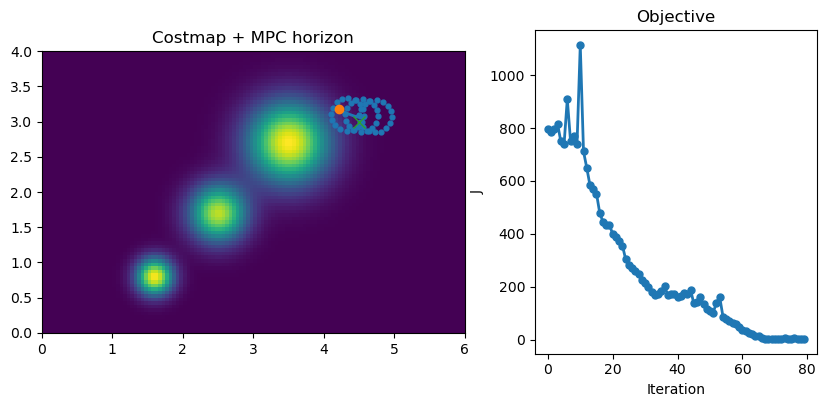

Done.


In [ ]:
# ---- Config ----
class CFG:
    seed = 7
    T = 0.15
    N = 12
    steps = 80
    vmin, vmax = -0.10, 0.60
    wmin, wmax = -1.2, 1.2
    Q = torch.diag(torch.tensor([8.0, 8.0, 0.2], dtype=torch.float32))
    R = torch.diag(torch.tensor([0.10, 0.05], dtype=torch.float32))
    S = torch.diag(torch.tensor([4.0, 4.0, 0.5], dtype=torch.float32))
    # obstacle
    fp_radius = 0.18
    safe_margin = 0.05
    cm_weight = 300.0
    cm_power = 2.0
    cm_thresh = 0.20
    ahead = [0.0, 0.20, 0.40]
    samples_per_circle = 16
    # map
    grid_W, grid_H, grid_res = 120, 80, 0.05
    sleep_s = 0.00  # fast

random.seed(CFG.seed); np.random.seed(CFG.seed); torch.manual_seed(CFG.seed)

# ---- Build synthetic costmap ----
grid, ox, oy, res = make_gaussian_costmap(
    CFG.grid_W, CFG.grid_H, CFG.grid_res,
    peaks=[(1.6, 0.8, 0.18, 1.0), (2.5, 1.7, 0.28, 0.9), (3.5, 2.7, 0.4, 1.0)]
)
cm = CostmapGrid(grid, ox, oy, res)

# ---- Subsystems ----
robot = Robot(dt=CFG.T, v_limits=(CFG.vmin, CFG.vmax), w_limits=(CFG.wmin, CFG.wmax),
              footprint_radius=CFG.fp_radius, safety_margin=CFG.safe_margin)
penalty = ObstaclePenalty(
    cm,
    ObstacleParams(
        weight=CFG.cm_weight, power=CFG.cm_power, thresh=CFG.cm_thresh,
        unknown_is_lethal=True, ahead_dists=CFG.ahead,
        samples_per_circle=CFG.samples_per_circle,
        footprint_radius=CFG.fp_radius, safety_margin=CFG.safe_margin
    )
)
opt = Optimizer(N=CFG.N, robot=robot, Q=CFG.Q, R=CFG.R, S=CFG.S, T=CFG.T,
                penalty=penalty, iters=8, time_frac=0.5)
planner = TrajectoryPlanner(lock_radius=0.5)

# ---- Live figure ----
plt.ion()
fig, (ax_map, ax_loss) = plt.subplots(1,2, figsize=(10,4.2), gridspec_kw={'width_ratios':[3,2]})
im = ax_map.imshow(grid, origin="lower", extent=[ox, ox+CFG.grid_W*res, oy, oy+CFG.grid_H*res], vmin=0, vmax=1)
ax_map.set_title("Costmap + MPC horizon")
ax_map.set_aspect("equal")

from IPython.display import display, clear_output

path_x, path_y = [], []
hline, = ax_map.plot([], [], lw=2)
robot_dot, = ax_map.plot([], [], marker='o', ms=6)
goal_dot,  = ax_map.plot([], [], marker='x', ms=8)
samples_scatter = ax_map.scatter([], [], s=12)

loss_vals = []
# use markers so a single point is visible
loss_line, = ax_loss.plot([], [], 'o-', lw=2, markersize=5)
ax_loss.set_title("Objective")
ax_loss.set_xlabel("Iteration"); ax_loss.set_ylabel("J")

# Initial draw
display(fig)
fig.canvas.draw(); fig.canvas.flush_events()

def update_plot(X_pred, x, dbg):
    path_x.append(float(x[0])); path_y.append(float(x[1]))
    hline.set_data(X_pred[:,0], X_pred[:,1])
    robot_dot.set_data([x[0]], [x[1]])
    goal_dot.set_data([planner.goal.x], [planner.goal.y])
    # Samples
    if dbg and dbg.get("samples"):
        try:
            sx = [s[0] for s in dbg["samples"]]
            sy = [s[1] for s in dbg["samples"]]
            import numpy as _np
            samples_scatter.set_offsets(_np.c_[sx, sy])
        except Exception:
            pass

    # redraw map panel
    ax_map.figure.canvas.draw()
    ax_map.figure.canvas.flush_events()

def main():
    x = torch.tensor([0.2, 0.2, 0.0], dtype=torch.float32)
    loss_vals.clear()
    for step in range(CFG.steps):
        ref = planner.build_reference(x.tolist(), CFG.N)
        u0, Xpred = opt.solve(x, ref)
        x = Xpred[1,:].clone()
        loss, _ = opt.rollout_cost(Pose2D.from_vector(x), ref)
        loss_vals.append(float(loss.item()))
        loss_line.set_data(range(len(loss_vals)), loss_vals)
        ax_loss.relim(); ax_loss.autoscale_view()

        update_plot(Xpred.numpy(), x.numpy(), penalty.debug)

        # robust live update in notebooks
        clear_output(wait=True)
        display(fig)
        try:
            fig.canvas.draw_idle()
            fig.canvas.flush_events()
        except Exception:
            pass

        if CFG.sleep_s > 0:
            time.sleep(CFG.sleep_s)
    print("Done.")

main()